<center> <a href = "TableOfContents.ipynb">Table of Contents &lt;</a> | <a href = Languages.ipynb>&gt; Language Use</a> <center>

# Growth in Popularity of Notebooks on Github 
This notebook looks into how the popularity of notebooks has increased over the years. In 2017, Adam Rule "scraped and analyzed 1.23 million publicly available Jupyter Notebooks on GitHub". That number has over tripled in only two years, now with over five million notebooks. 

Approximately 18% of all notebooks are in an ipynb_checkpoints folder within their given GitHub repository. Ipynb_checkpoints is a version control feature of Jupyter, so these notebooks are duplicates (or very recent versions, so near duplicates) of other notebooks in the repository. We don't want to double count notebooks, so all ipynb_checkpoints notebooks are removed prior to analysis. 

For each notebook, we have access to the following dates: 'created at', 'pushed at', and 'updated at'.
- *Created At*: When the repository was created. May be older dates than the notebooks themselves, and does not reflect updates since creation.
- *Pushed At*: When the repository was most recently pushed to. The best indicator of the last true update. However, when looking at popularity, it would count updated notebooks incorrectly as 'new' notebooks, pushing the distribution of notebooks over time to the right. Further, the notebook may not have been changed in the most recent push to the repository.
- *Updated At*: This is when the repository was last updated. An 'update' can include more than new code -- also looks at if language has changed, if there's a new stargazer, or if a contributor has been added. This isn't always related to file updates, so is not very useful.
- **For analysis on notebook popularity, 'Created At' makes the most sense.**
- **All future analysis will use 'Pushed At' as the date metric (considering that package use, language version, etc. could have changed on 'Pushed At' date).**

## Results summary:
- 75.0% of all notebooks on GitHub were created after Adam's research, 42.59% in the past year (between August 2018 - July 2019).

------------

# Import Packages & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import calendar

import load_data
import datetime

In [2]:
# load data frames
repos = load_data.load_repos()
notebooks = load_data.load_notebooks()


Repos loaded in 0:00:04.339268
Notebooks loaded in 0:00:26.046253


-----

# Manipulate Data

### Monthly counts
Add month and year created to notebooks dataframe.

In [3]:
# about 45 seconds
start = datetime.datetime.now()

DATE_CHOICE = 'created_at'
over_time = notebooks.merge(repos, on = 'repo_id').copy()[['file',DATE_CHOICE]]
over_time[DATE_CHOICE] = pd.to_datetime(over_time[DATE_CHOICE])
over_time['month'] = [c.month for c in over_time[DATE_CHOICE]]
over_time['year'] = [c.year for c in over_time[DATE_CHOICE]]
over_time = over_time.drop_duplicates(subset = ['file'])

end = datetime.datetime.now()
print(end - start)

0:00:55.829281


Add number of notebooks per month, date labels, and cumulative notebooks

In [4]:
start = datetime.datetime.now()

# Calculate number of notebooks per month
monthly_counts = over_time[over_time.year > 2012].groupby(
    ['year', 'month']
)['file'].count().reset_index().rename(
    columns={'file':'count'}
)

# Add zeros for months with no new notebooks
to_append = {'year':[],'month':[],'count':[]}
for year in range(2013, 2020):
    if year == 2019:
        r = range(1, 7)
    else:
        r = range(1, 13)
        
    for month in r:
        if len(monthly_counts[
            np.logical_and(
                monthly_counts.year == year, 
                monthly_counts.month == month
            )
        ]) == 0:
            to_append['year'].append(year)
            to_append['month'].append(month)
            to_append['count'].append(0)
            
monthly_counts = pd.concat(
    [monthly_counts, pd.DataFrame(to_append)], sort = False
).sort_values(by = ['year','month'])

# Add labels for January of each year (to be on X axis)
monthly_counts['labels'] = [
    calendar.month_name[int(row['month'])] + \
    ' '+ str(int(row['year'])) if i%6 == 0 else ''
    for i, row in monthly_counts.iterrows()
]

# Order = number of months since January 2013
monthly_counts['order'] = list(range(len(monthly_counts)))
monthly_counts = monthly_counts.reset_index(drop = True)

# Calculate cumulative number of notebooks
cumulative = [monthly_counts['count'][0]]
for i in range(1,len(monthly_counts)):
    cumulative.append(monthly_counts['count'].iloc[i] + cumulative[i-1])
    
monthly_counts['cumulative'] = cumulative
monthly_counts['cumulative_percentile'] = monthly_counts['cumulative']/monthly_counts['count'].sum()

end = datetime.datetime.now()
print(end - start)


0:00:00.881039


-----

# Visualizations & Statistics

## Plot cumulative number of notebooks over time. 
Leave out July 2019 and on. The number of notebooks for these months are underestimated because GitHub was queried before the end of July.

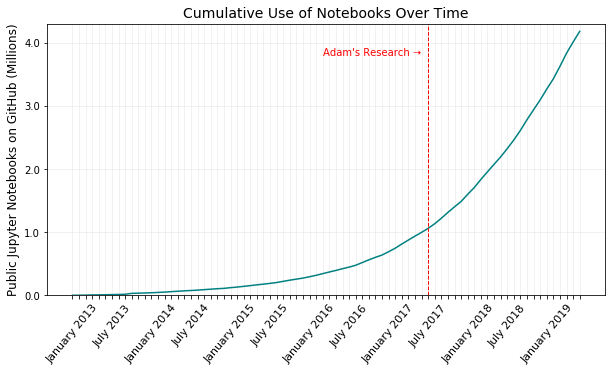

In [5]:
july_2019_idx = monthly_counts[np.logical_and(
    monthly_counts.year == 2019, 
    monthly_counts.month == 7
)].order.values[0]

fig = plt.figure(figsize=(10, 5))
plt.plot(
    monthly_counts['order'][:july_2019_idx],
    monthly_counts['cumulative'][:july_2019_idx], 
    color = 'teal'
)
plt.xticks(
    monthly_counts['order'][:july_2019_idx],
    monthly_counts['labels'][:july_2019_idx], 
    fontsize=11, rotation=50
)
plt.ylabel('Public Jupyter Notebooks on GitHub (Millions)', fontsize = 12)
plt.yticks(range(0, 4300000, 1000000), [i/10 for i in range(0, 43, 10)])
plt.ylim(0, 4300000)
plt.title('Cumulative Use of Notebooks Over Time', fontsize = 14)

plt.axvline(54, color = 'red', linewidth = 1, linestyle = '--')
plt.text(38, 3800000, 'Adam\'s Research ➝', color = 'red')

plt.grid(alpha = 0.2)
plt.show()

#### Is this exponential?
In Adam's report, he mentioned that the growth of notebooks on GitHub was exponential as of July 2017. Is this still true?

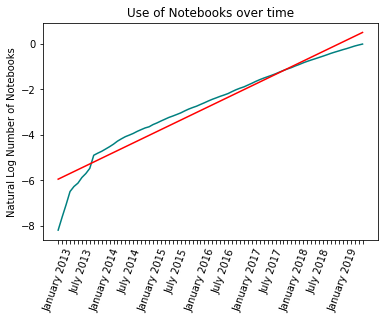

In [6]:
x = monthly_counts['order'][:july_2019_idx]
labels = monthly_counts['labels'][:july_2019_idx]
y = [math.log(y) if y != 0 else 0 
     for y in monthly_counts['cumulative_percentile'][:july_2019_idx]
]

best_fit = np.polyfit(x, y, 1)

plt.plot(x, y, color = 'teal')
plt.xticks(x, labels, rotation = 70)
plt.plot(np.unique(x), np.poly1d(best_fit)(np.unique(x)), color = 'red')

plt.ylabel('Natural Log Number of Notebooks')
plt.title('Use of Notebooks over time')
plt.show()

An exponential model does not fit the data very well.

## Plot number of new notebooks per month. 

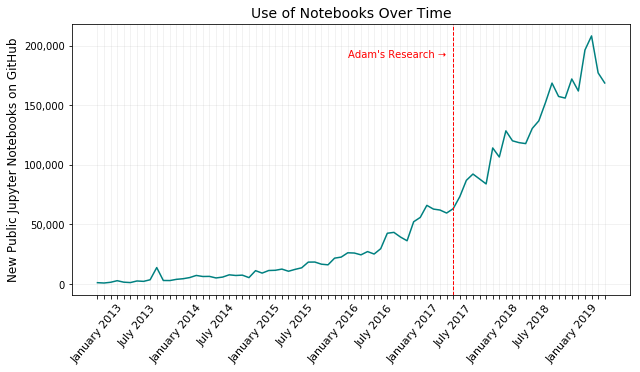

In [7]:
# add proportion of total notebooks to monthly counts dataframe
monthly_counts['prop'] = monthly_counts['count']/monthly_counts['count'].sum()

fig = plt.figure(figsize=(10, 5))
plt.plot(
    monthly_counts['order'][:july_2019_idx],
    monthly_counts['count'][:july_2019_idx], 
    color = 'teal'
)
plt.xticks(
    monthly_counts['order'][:july_2019_idx], 
    monthly_counts['labels'][:july_2019_idx], 
    fontsize=11, rotation=50
)
plt.yticks(
    range(0, 210000, 50000), 
    ['{0:,}'.format(i) for i in range(0, 210000, 50000)]
)
plt.ylabel(
    'New Public Jupyter Notebooks on GitHub'.format(
        round(len(notebooks)/1000000, 2)
    ), 
    fontsize = 12
)
plt.title('Use of Notebooks Over Time', fontsize = 14)

plt.axvline(54, color = 'red', linewidth = 1, linestyle = '--')
plt.text(38, 190000, 'Adam\'s Research ➝', color = 'red')

plt.grid(alpha = 0.2)
plt.show()

In [8]:
aug_2018_idx = monthly_counts[
    np.logical_and(
        monthly_counts.year == 2018, 
        monthly_counts.month == 8
    )
].index[0]


print("{0}% of all notebooks on GitHub were created after Adam's research".format(
      round(100 - 100*monthly_counts[
          np.logical_and(
              monthly_counts.year == 2017, 
              monthly_counts.month == 7
          )].cumulative_percentile.values[0]
)))

print("{0}% of all notebooks on GitHub were created in the past year (between August 2018 - July 2019).".format(
    round(100*monthly_counts[monthly_counts.order > aug_2018_idx].prop.sum(), 2)
), end = ' ')
print("That's {:,} notebooks.".format(int(
    monthly_counts[np.logical_and(
        monthly_counts.order > aug_2018_idx,
        monthly_counts.order < july_2019_idx
    )]['count'].sum()
)))

75.0% of all notebooks on GitHub were created after Adam's research
42.59% of all notebooks on GitHub were created in the past year (between August 2018 - July 2019). That's 1,718,175 notebooks.


<center> <a href = "TableOfContents.ipynb">Table of Contents &lt;</a> | <a href = Languages.ipynb>&gt; Language Use</a> <center>